
# **Predicting Treatment Plans for Patients**

Problem statement: Develop a machine learning model to accurately predict specific medical treatments for patients, based on a comprehensive set of diagnostic and demographic features. This predictive model aims to support medical professionals by providing data-driven treatment recommendations.

Features:
The dataset for this model includes:

* age: Patient's age described qualitatively (e.g., "4-year-old").
* sex: Patient's sex (e.g., "Girl").
* physiological_context: General health status before current medical interaction (e.g., "Previously healthy").
* visit_motivation: Initial reason for the medical visit (e.g., "Routine checkup").
* admission_reason: Specific cause for admission (e.g., "Abdominal mass").
* diagnosis_test: Type of diagnostic tests conducted (e.g., "Pathology").
* diagnosis_result: Outcomes from the diagnostic tests (e.g., "Favorable histology").
* related_condition: Diagnosed medical conditions (e.g., "Wilms tumor").
* reason_for_treatment: Basis for the recommended treatment (e.g., "Stage II treatment").

Target Variable:
* treatment_name: Type of treatment prescribed, including antibiotics, chemotherapy, surgery, etc.

Here is the link to the dataset:
https://drive.google.com/file/d/1CR5_lEImN8umGYFMWMtP4wouJYYhEjNY/view?usp=share_link

* This dataset has been downloaded and processed from Hugging face library

# Install necessary libraries (Ignore if already done)

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install imbalanced-learn
# !pip install spacy
# !pip install matplotlib
# !pip install seaborn
# !python -m spacy download en_core_web_sm
# !pip install --upgrade scikit-learn
# !pip install --upgrade imbalanced-learn

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import spacy

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.utils.data import Dataset


# Loading Data

In [3]:
df = pd.read_csv('t2.csv')  

# View of data

In [4]:
pd.set_option('display.max_colwidth', None)
df.head(3)

,age,sex,physiological_context,visit_motivation,admission_reason,diagnosis_test,diagnosis_result,related_condition,reason_for_treatment,treatment_name
0,4-year-old,Girl,Previously healthy,Routine surveillance chest radiograph,"Painless, right-sided abdominal mass",Pathology,Favorable histology and negative margins,Wilms tumor,Standard treatment for Stage II Wilms tumor,Chemotherapy
1,47,Female,Past medical history includes a right thyroid lobectomy for a large benign thyroid nodule and cyst about two years ago.,"Chest pain and dyspnea, weight loss",Suspected lung cancer with distant metastasis (clinical stage IV),Lung biopsy,Primary lung adenocarcinoma with predominantly micropapillary carcinoma component,Primary lung adenocarcinoma,Treatment for diagnosed primary lung adenocarcinoma,Chemotherapy
2,51,male,Muscle-invasive urothelial cell carcinoma diagnosed in May 2015,New exertional dyspnea and syncopal episode,Progressive dyspnea with minimal exertion and syncopal episode,PET/CT scan,Complete metabolic response in the right ventricle mass,Right ventricular mass,Mass was not resectable and chemotherapy was not felt to offer rapid disease control,Palliative radiotherapy


# About the data

In [5]:
#Shape
print(f"---------shape of the dataframe--------\n {df.shape}")

# null values
print("\n--------null values of dataframe:----------- ")
print(df.isna().sum())

# datatypes of all columns
print("\n--------Datatypes of all columns----------- ")
print(df.dtypes)

# unique values in diagnosis (label colum)
df['treatment_name'] = df['treatment_name'].str.lower()
print(f"\n -----------------Unique treatments:-------------\n {df['treatment_name'].nunique()}")
df["treatment_name"].value_counts()


---------shape of the dataframe--------
 (10101, 10)

--------null values of dataframe:----------- 
age                      0
sex                      0
physiological_context    0
visit_motivation         0
admission_reason         0
diagnosis_test           0
diagnosis_result         0
related_condition        0
reason_for_treatment     0
treatment_name           0
dtype: int64

--------Datatypes of all columns----------- 
age                      object
sex                      object
physiological_context    object
visit_motivation         object
admission_reason         object
diagnosis_test           object
diagnosis_result         object
related_condition        object
reason_for_treatment     object
treatment_name           object
dtype: object

 -----------------Unique treatments:-------------
 100


treatment_name
antibiotics                614
chemotherapy               474
aspirin                    375
blood transfusion          309
conservative management    296
                          ... 
nivolumab                   27
losartan                    26
oral steroids               21
omeprazole                  20
risperidone                 12
Name: count, Length: 100, dtype: int64

# Data Cleaning 

## Sex Column

In [6]:
# Function to standardize sex values
def standardize_sex(sex):
    if pd.isna(sex):
        return None
    return sex.strip().capitalize()

# Apply the conversion function
df['sex'] = df['sex'].apply(standardize_sex)

#data[['patient information_sex']].count()
sex_counts = df['sex'].value_counts()
print(sex_counts)



sex
Male                 5117
Female               3711
Woman                 997
Man                   156
Boy                    59
Girl                   52
Gentleman               6
Male (geminus a)        2
Sex not specified       1
Name: count, dtype: int64


In [7]:
# Function to standardize sex values
def standardize_sex(sex):
    if pd.isna(sex):
        return 'Unknown'
    sex = sex.strip().lower()
    if sex in ['male', 'man', 'boy', 'gentleman', 'male (geminus a)']:
        return 'Male'
    elif sex in ['female', 'woman', 'girl']:
        return 'Female'
    else:
        return 'Unknown'

# Apply the conversion function
df['sex'] = df['sex'].apply(standardize_sex)

# Count the occurrences of each category
sex_counts = df['sex'].value_counts()
print(sex_counts)

sex
Male       5340
Female     4760
Unknown       1
Name: count, dtype: int64


## Age Column

In [8]:
# Display unique values in the 'patient information_age' column
unique_age_values = df['age'].unique()
unique_age_values

array(['4-year-old', '47', '51', '59', '65', '48', '25 years old', '43',
       '64', '70-year-old', '71', '77', '58', '36', '55', '32', '37',
       'Sixty-seven', '66', '72', '57', '30', '56 years old', '73', '21',
       '67 years old', '53', '49', '83', '26 years', '61', '57 years old',
       '27 years old', '24 days old', '50-year-old', '7-month-old',
       'Newborn', '87 years old', '24 years old', '86', '55 years old',
       '23 years old', '20', '18-year-old', '38', '16 years old',
       'One year', '35', '44', '69', '81 years old', '46 years old', '41',
       '85', '34', '63', '27', '16-year-old', '19', '76 years old', '60',
       '25', '52', '29', '1-day-old', '68 years-old', '45 years old',
       '56', '54', '39', '62', '11 years old', '31', '45', '68-year-old',
       '26', '10 years old', '75', '67', '65 years old', '49 years old',
       'Thirty-four-year-old', '2 years old', '79', '60s', '7 weeks old',
       '84', '16', 'three-year old', '34 years old', '6-year-o

In [9]:
# Function to extract and standardize age values
def extract_age(age):
    if pd.isna(age):
        return None
    match = re.search(r'\d+', str(age))
    if match:
        return int(match.group())
    return None

# Apply the extraction function
df['age'] = df['age'].apply(extract_age)

# Verify the unique values after standardization
unique_age_values_standardized = df['age'].unique()
unique_age_values_standardized


array([ 4., 47., 51., 59., 65., 48., 25., 43., 64., 70., 71., 77., 58.,
       36., 55., 32., 37., nan, 66., 72., 57., 30., 56., 73., 21., 67.,
       53., 49., 83., 26., 61., 27., 24., 50.,  7., 87., 86., 23., 20.,
       18., 38., 16., 35., 44., 69., 81., 46., 41., 85., 34., 63., 19.,
       76., 60., 52., 29.,  1., 68., 45., 54., 39., 62., 11., 31., 10.,
       75.,  2., 79., 84.,  6., 74., 40., 13., 89., 33., 22., 14.,  8.,
        3., 28., 82., 17., 88., 42., 15.,  9.,  5., 93., 80., 78., 95.,
       12., 90., 92., 94.])

In [10]:
print("Null values before imputing", df['age'].isna().sum())
median_age = df['age'].median()
df['age'] = df['age'].fillna(median_age)
print("Null values before imputing with median ",df['age'].isna().sum())
df['age'] = df['age'].astype(int)
df["age"] = df["age"].astype(str)

Null values before imputing 182
Null values before imputing with median  0


## Target Column

In [11]:
# Function to standardize treatment names
def standardize_treatment_name(treatment):
    treatment = treatment.lower()
    if treatment in ['antibiotics', 'antibiotic therapy', 'antibiotic treatment', 'oral antibiotics', 'broad-spectrum antibiotics', 'broad spectrum antibiotics', 'intravenous antibiotics', 'empiric antibiotics']:
        return 'antibiotics'
    elif treatment in ['oral prednisolone', 'oral prednisone', 'prednisone', 'prednisolone', 'methylprednisolone', 'betamethasone', 'dexamethasone']:
        return 'corticosteroids'
    elif treatment in ['surgical excision', 'surgery', 'surgical resection', 'surgical intervention', 'surgical treatment']:
        return 'surgery'
    elif treatment in ['radiotherapy', 'radiation therapy', 'adjuvant radiotherapy']:
        return 'radiotherapy'
    elif treatment in ['intravenous hydrocortisone', 'oral steroids', 'steroids']:
        return 'steroids'
    elif treatment in ['heparin drip', 'heparin infusion', 'heparin']:
        return 'heparin'
    elif treatment in ['blood transfusion', 'blood transfusions']:
        return 'blood transfusion'
    elif treatment in ['adjuvant chemotherapy', 'neoadjuvant chemotherapy', 'palliative chemotherapy', 'chemotherapy']:
        return 'chemotherapy'
    elif treatment in ['fluid resuscitation', 'resuscitation']:
        return 'resuscitation'
    else:
        return treatment

# Apply the function to the treatment_name column
df['treatment_name'] = df['treatment_name'].apply(standardize_treatment_name)

# Print the unique values after standardization
print(f"\n -----------------Unique treatments after standardization:-------------\n {df['treatment_name'].nunique()}")
print(f"\n -----------------Unique treatment names after standardization:-------------\n {df['treatment_name'].unique()}")


 -----------------Unique treatments after standardization:-------------
 71

 -----------------Unique treatment names after standardization:-------------
 ['chemotherapy' 'palliative radiotherapy' 'sorafenib' 'hemodialysis'
 'conservative treatment' 'corticosteroids' 'surgery' 'aspirin' 'steroids'
 'azathioprine' 'clopidogrel' 'radiotherapy' 'analgesia' 'atorvastatin'
 'warfarin' 'metformin' 'antibiotics' 'conservative management'
 'methotrexate' 'furosemide' 'heparin' 'tacrolimus' 'meropenem'
 'amlodipine' 'nivolumab' 'infliximab' 'resuscitation' 'sunitinib'
 'symptomatic treatment' 'proton pump inhibitor' 'omeprazole'
 'levothyroxine' 'intubation' 'medication' 'acyclovir' 'apixaban'
 'cyclophosphamide' 'blood transfusion' 'levetiracetam' 'ciprofloxacin'
 'physiotherapy' 'vancomycin' 'carbamazepine' 'transfusion' 'losartan'
 'physical therapy' 'doxycycline' 'ceftriaxone' 'imatinib'
 'hydroxychloroquine' 'anticoagulation' 'embolization' 'ibuprofen'
 'analgesics' 'inotropic support' 'a

In [12]:
# Lowercase treatment_name column
df['treatment_name'] = df['treatment_name'].str.lower()

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print unique treatments count and value counts
print(f"\n -----------------Unique treatments:-------------\n {df['treatment_name'].nunique()}")
print(df["treatment_name"].value_counts())



 -----------------Unique treatments:-------------
 71
treatment_name
antibiotics                       1409
corticosteroids                    876
chemotherapy                       777
surgery                            721
blood transfusion                  385
aspirin                            375
radiotherapy                       335
conservative management            296
conservative treatment             279
heparin                            205
resuscitation                      181
warfarin                           176
ceftriaxone                        162
steroids                           158
clopidogrel                        157
vancomycin                         136
levetiracetam                      128
mechanical ventilation             114
atorvastatin                       112
intravenous fluids                 106
sunitinib                           95
imatinib                            95
intubation                          95
analgesics                       

In [13]:
# Removing classes where total records is less than 100

# Calculate value counts for each treatment_name
counts = df['treatment_name'].value_counts()

# Filter treatment names with count >= 100
filtered_treatment_names = counts[counts >= 100].index

# Filter the original DataFrame based on filtered treatment names
df = df[df['treatment_name'].isin(filtered_treatment_names)]


In [14]:
# Lowercase treatment_name column
df['treatment_name'] = df['treatment_name'].str.lower()

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print unique treatments count and value counts
print(f"\n -----------------Unique treatments:-------------\n {df['treatment_name'].nunique()}")
print(df["treatment_name"].value_counts())



 -----------------Unique treatments:-------------
 20
treatment_name
antibiotics                1409
corticosteroids             876
chemotherapy                777
surgery                     721
blood transfusion           385
aspirin                     375
radiotherapy                335
conservative management     296
conservative treatment      279
heparin                     205
resuscitation               181
warfarin                    176
ceftriaxone                 162
steroids                    158
clopidogrel                 157
vancomycin                  136
levetiracetam               128
mechanical ventilation      114
atorvastatin                112
intravenous fluids          106
Name: count, dtype: int64


In [15]:
#all lower
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

#remove duplicates
df.drop_duplicates(inplace=True)
print(f"shape of dataframe after removing duplicates: {df.shape}")

shape of dataframe after removing duplicates: (7020, 10)


# Data after cleaning 

In [16]:
pd.set_option('display.max_colwidth', None)
df.head(5)

,age,sex,physiological_context,visit_motivation,admission_reason,diagnosis_test,diagnosis_result,related_condition,reason_for_treatment,treatment_name
0,4,female,previously healthy,routine surveillance chest radiograph,"painless, right-sided abdominal mass",pathology,favorable histology and negative margins,wilms tumor,standard treatment for stage ii wilms tumor,chemotherapy
1,47,female,past medical history includes a right thyroid lobectomy for a large benign thyroid nodule and cyst about two years ago.,"chest pain and dyspnea, weight loss",suspected lung cancer with distant metastasis (clinical stage iv),lung biopsy,primary lung adenocarcinoma with predominantly micropapillary carcinoma component,primary lung adenocarcinoma,treatment for diagnosed primary lung adenocarcinoma,chemotherapy
5,48,female,"sciatic pain for seven years, endometriosis, symptomatic pulmonary embolism, hypoplasia of the inferior vena cava, bilateral occlusion of vena iliaca communis",exacerbation of nerve root irritation,increased sciatica symptoms and conservative treatment,diagnostic evaluation for thrombophilia,"hypoplasia of the inferior vena cava, bilateral occlusion of vena iliaca communis, collateral pathway with ectatic enlargement of the veins of the lesser pelvis",sciatic pain,decrease in symptoms,conservative treatment
6,25,female,"primigravida, chronic hypertension, active ta",active labor and later severe fetal growth restriction and neurological sequelae of aortoarteritis,severe fetal growth restriction and neurological sequelae of aortoarteritis,mra scan,markedly attenuated flow in left cca,active ta,treatment for active ta,corticosteroids
7,43,male,history of nasal trauma 17 years ago,inability to breathe through left nostril and swelling on nasal tip,complaints of inability to breathe through left nostril and swelling on nasal tip,ct of the paranasal sinuses,large soft tissue mass lesion,mass lesion on left nasal dorsum,to remove the mass lesion,surgery


# Preprocessing

In [17]:
#Label the target variable
df_model= df
label_encoder = LabelEncoder()
df_model['label'] = label_encoder.fit_transform(df_model['treatment_name'])

In [18]:
# X = df_model.drop(['diagnosis','label'], axis=1)  # Features
df_model["X"]= ( df_model["age"] + " " + df_model["sex"] + " " + df_model["visit_motivation"] + " " + df_model["physiological_context"] + " "
     + df_model["admission_reason"] + " " + df_model["diagnosis_test"] + " " + df_model["diagnosis_result"] +
     " " + df_model["related_condition"] + " " + df_model["reason_for_treatment"])

In [19]:
# data preprocess- remove punct and all.
#1. remove the punctuation and stopwords
#2. lemmatize to the base words


nlp= spacy.load("en_core_web_sm")

# Custom stop words list to retain medical terms and important words
custom_stopwords = set(spacy.lang.en.stop_words.STOP_WORDS) - {'clinical', 'diagnose', 'medical', 'history', 'suspect', 'treatment'}

def preprocess(text):
    doc = nlp(str(text))
    filtered_token = []

    for token in doc:
        if token.is_stop and token.text.lower() in custom_stopwords:
            continue
        if token.is_punct:
            continue
        filtered_token.append(token.lemma_)

    return " ".join(filtered_token)

In [20]:
# Before Preprocess
print(df_model['X'].iloc[1])

47 female chest pain and dyspnea, weight loss past medical history includes a right thyroid lobectomy for a large benign thyroid nodule and cyst about two years ago. suspected lung cancer with distant metastasis (clinical stage iv) lung biopsy primary lung adenocarcinoma with predominantly micropapillary carcinoma component primary lung adenocarcinoma treatment for diagnosed primary lung adenocarcinoma


In [21]:
df_model["tokens"]= df_model['X'].apply(preprocess)
print(df_model['tokens'].iloc[1])

47 female chest pain dyspnea weight loss past medical history include right thyroid lobectomy large benign thyroid nodule cyst year ago suspect lung cancer distant metastasis clinical stage iv lung biopsy primary lung adenocarcinoma predominantly micropapillary carcinoma component primary lung adenocarcinoma treatment diagnose primary lung adenocarcinoma


In [22]:
# TF-IDF

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_model['tokens'])
y = df_model['label']

# Train-Test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the number of samples in each dataset
print("Number of samples in training set:", X_train.shape[0])
print("Number of samples in test set:", X_test.shape[0])

Number of samples in training set: 5616
Number of samples in test set: 1404


# Models- Traditional

### All relevant models with CV=5 and with basic tuning 

In [26]:
# Defining classifiers to test
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Loop through classifiers
for name, classifier in classifiers.items():
    pipeline = make_pipeline(SMOTE(random_state=42), classifier)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"{name}: Cross-validation F1-weighted scores  = {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}")
    
    # Fit and evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} - Test Accuracy: {accuracy:.4f}, F1 Score (Weighted): {f1:.4f}\n")

Logistic Regression: Cross-validation F1-weighted scores  = 0.7832 +/- 0.0048
Logistic Regression - Test Accuracy: 0.8291, F1 Score (Weighted): 0.8309

SVM: Cross-validation F1-weighted scores  = 0.8048 +/- 0.0100
SVM - Test Accuracy: 0.8504, F1 Score (Weighted): 0.8504

Random Forest: Cross-validation F1-weighted scores  = 0.7956 +/- 0.0038
Random Forest - Test Accuracy: 0.8319, F1 Score (Weighted): 0.8321

K-Nearest Neighbors: Cross-validation F1-weighted scores  = 0.6725 +/- 0.0071
K-Nearest Neighbors - Test Accuracy: 0.7400, F1 Score (Weighted): 0.7471



## We will stick to SVM and Random forest for further modelling with CV=5 and hyperparameter tuning .

## Random Forest Hyperparameter Tuning with Including Class Weights, SMOTE and Cross validation

In [41]:
# Splitting the data into a smaller subset for tuning
_, X_tune, _, y_tune = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

# Define the model pipeline
pipeline_rf = make_pipeline(SMOTE(random_state=42), RandomForestClassifier(random_state=42))

# Reduced parameters of the model
param_grid_rf = {
    'randomforestclassifier__n_estimators': [100, 200],  # Reduced to two options
    'randomforestclassifier__max_features': ['sqrt'],  # Use only the most common option
    'randomforestclassifier__max_depth': [None, 20],  # Reduced depth options
    'randomforestclassifier__min_samples_split': [2, 5],  # Fewer split options
    'randomforestclassifier__min_samples_leaf': [1, 2],  # Fewer leaf options
    'randomforestclassifier__class_weight': ['balanced']  # Stick to one class weighting strategy
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Setup GridSearchCV
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=skf, scoring='f1_weighted', verbose=1, error_score='raise')
grid_search_rf.fit(X_tune, y_tune)

# Print the best parameters and the corresponding score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for Random Forest: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200}


In [42]:
# Apply the best parameters to the full training data
rf_best = grid_search_rf.best_estimator_

# Re-train on the entire training set using the best parameters
rf_best.fit(X_train, y_train)

# Evaluate on the full test set
y_pred_rf = rf_best.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Print final test results
print("Random Forest - Test Accuracy: {:.4f}, F1 Score (Weighted): {:.4f}".format(accuracy_rf, f1_rf))

Random Forest - Test Accuracy: 0.8369, F1 Score (Weighted): 0.8373


## SVM Hyperparameter Tuning with Including Class Weights, SMOTE and Cross validation

In [24]:
# Splitting the data into a smaller subset for tuning
_, X_tune, _, y_tune = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

# Define the model pipeline
pipeline_svm = make_pipeline(SMOTE(random_state=42), SVC(probability=True, random_state=42))

# Parameters of the model
param_grid_svm = {
    'svc__C': [0.1, 1, 10,50],  # Regularization parameter
    'svc__kernel': ['linear', 'rbf'],  # Type of hyperplane used to separate the data
    'svc__gamma': ['scale', 'auto'],  # Kernel coefficient
    'svc__class_weight': ['balanced']  # Balancing class weights
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Setup GridSearchCV
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=skf, scoring='f1_weighted', verbose=1)
grid_search_svm.fit(X_tune, y_tune)

# Best parameters and scores
print("Best parameters for SVM:", grid_search_svm.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
32 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/imblearn/pipeline.py", line 

Best parameters for SVM: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'linear'}


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# Apply the best parameters to the full training data
svm_best = grid_search_svm.best_estimator_

# Re-train on the entire training set using the best parameters
svm_best.fit(X_train, y_train)

# Evaluate on the full test set
y_pred_svm = svm_best.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')

# Compute AUC score (one-vs-rest)
y_prob_svm = svm_best.predict_proba(X_test)
auc_svm = roc_auc_score(y_test, y_prob_svm, multi_class='ovr', average='weighted')

# Print SVM metrics
print(f"SVM - Test Accuracy: {accuracy_svm:.4f}")
print(f"SVM - Precision (Weighted): {precision_svm:.4f}")
print(f"SVM - Recall (Weighted): {recall_svm:.4f}")
print(f"SVM - F1 Score (Weighted): {f1_svm:.4f}")
print(f"SVM - AUC Score (Weighted): {auc_svm:.4f}\n")


SVM - Test Accuracy: 0.7678
SVM - Precision (Weighted): 0.7782
SVM - Recall (Weighted): 0.7678
SVM - F1 Score (Weighted): 0.7691
SVM - AUC Score (Weighted): 0.9790



In [50]:

precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')

# Printing all metrics
print(f'Test Accuracy for SVM: {accuracy_svm:.4f}')
print(f'Precision (Weighted) for SVM: {precision_svm:.4f}')
print(f'Recall (Weighted) for SVM: {recall_svm:.4f}')
print(f'F1 Score (Weighted) for SVM: {f1_svm:.4f}')

Test Accuracy for SVM: 0.8668
Precision (Weighted) for SVM: 0.8688
Recall (Weighted) for SVM: 0.8668
F1 Score (Weighted) for SVM: 0.8670


# Confusion Matrix- Heat Map

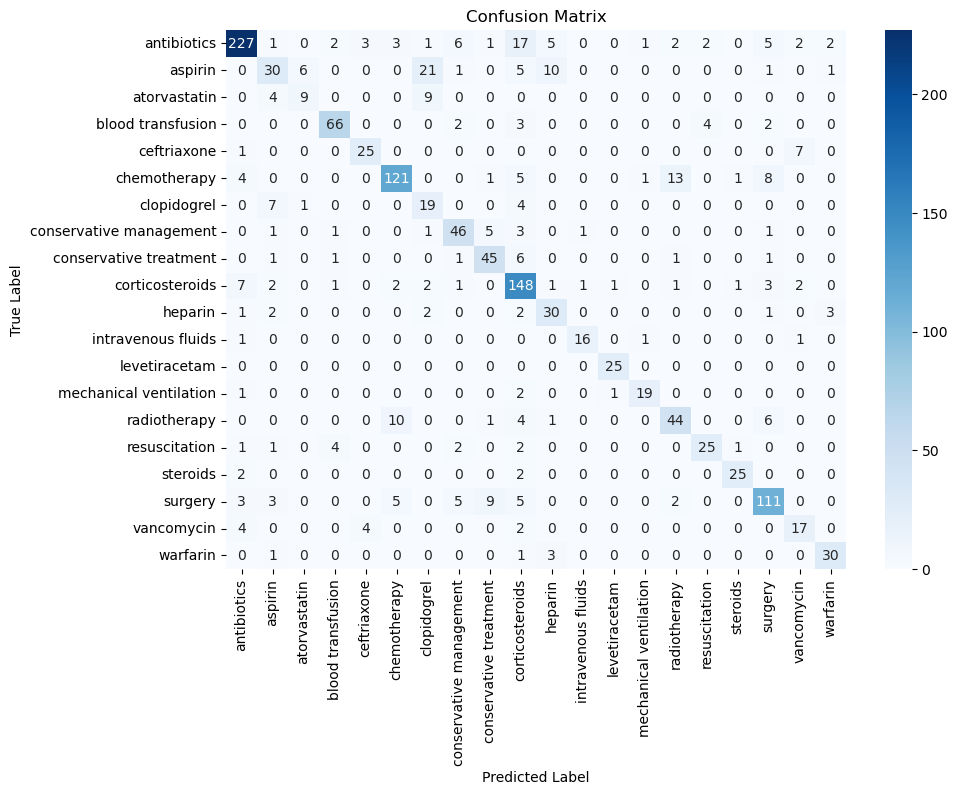

In [26]:
cm = confusion_matrix(y_test, y_pred_svm)

class_names = label_encoder.inverse_transform(np.unique(y_test))

plt.figure(figsize=(10, 7))  # Adjust size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()